# 10.2  Exercise

Amelia Farrell

DSC520

2/14/22


In [ ]:
# Loading packages needed
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import random

import thinkstats2
import thinkplot

In [ ]:
# Loading the data for the price of weed
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])

# Chapter 12

## Page 161: 12-1 
(The linear model I used in this chapter has the obvious drawback that it is linear and there is no reason to expect prices to change linearly over time…)


In [ ]:
# Creating a function to groups transactions by day and compute the daily mean into a dataframe.
def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

In [ ]:
# Creating a  function to return a map from quality name to a DataFrame of the daily averages.
def GroupByQualityAndDay(transactions):
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

dailies = GroupByQualityAndDay(transactions)

In [ ]:
# Running a linear model with quadratic term of prices versus years.
def RunQuadraticModel(daily):
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

In [ ]:
# Summary of linear model with quadratic term
name = 'high'
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Mon, 21 Feb 2022   Prob (F-statistic):          4.57e-164
Time:                        01:35:58   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Function for plotting the data to fitted values
def PlotFittedValues(model, results, label=''):
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='#ff7f00')

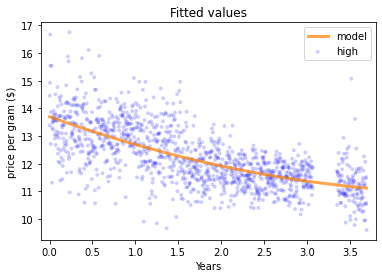

In [ ]:
# Plotting of our fitted vaules and actuals
PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted values',
                 xlabel='Years',
                 xlim=[-0.1, 3.8],
                 ylabel='price per gram ($)')

In [ ]:
# Function to resample from the residuals.
def SimulateResults(daily, iters=101, func=RunQuadraticModel):
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [ ]:
# Function to Generate Predictions using our model.
def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

In [ ]:
# Function to help us plot our predictions.
def PlotPredictions(daily, years, iters=101, percent=90, func=RunQuadraticModel):
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

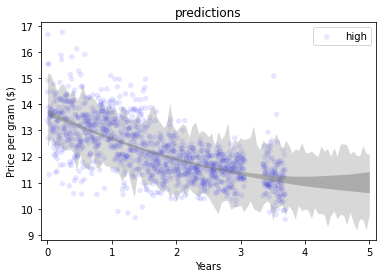

In [ ]:
# Plotting our predictions using the above functions.
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(title='predictions',
                 xlabel='Years',
                 xlim=[years[0]-0.1, years[-1]+0.1],
                 ylabel='Price per gram ($)')

## Page 161: 12-2 
(Write a definition for a class called SerialCorrelationTest that extends HypothesisTest from “HypothesisTest” on page 102…)

In [ ]:
# Function to compute a serial correlation with the given lag.
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [ ]:
# Creating a function using "statsmodels" to run a linear model of price as a function of time.
import statsmodels.formula.api as smf

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results 

In [ ]:
# Creating functing to test serial correlations by computing the test statistic and running a model of the null hypothesis.
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [ ]:
# Running a correlation between consecutive prices
name = 'high'
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Test Correlation:", test.actual," Test P-Value:", pvalue)

Test Correlation: 0.4852293761947382  Test P-Value: 0.0


Based off the above correlation in the raw price data, it is statistically significant (the p-vaule is < 0.05). Though the relantionship is weak at 0.48.  

In [ ]:
# Running a serial correlation of the residuals of the linear model
_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Linear Correlation:", test.actual, " Linear P-Value:", pvalue)

Linear Correlation: 0.07570473767506267  Linear P-Value: 0.011


Based off the results from the residuals of the linear model, the correlation is still statistically significant, however the relantionship is very weak or non exsistant at 0.07. 

In [ ]:
# Running a serial correlation of the residuals of the quadratic model
_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print("Quadractic Correlation:", test.actual, " Quadractic P-Value:", pvalue)

Quadractic Correlation: 0.05607308161289925  Quadractic P-Value: 0.048


Based off the results from the residuals of the  quadratic model, the correlation is even lless statistically significant (p>0.4) and the relantionship is non exsistant at 0.05. 